In [257]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


## Table of Contents:
* [Defining methods](#models)
* [Predicitng Poor Posture](#poor-posture)
* [Predicting Pain Severity](#pain-severity)
* [Predicting where someone may experience back pain](#pain-loc)
* [Predicting when someone may experience back pain](#pain-when)
* [Predicting sleep habits](#sleep)
* [Predicting activity levels](#activity)

In [353]:
#read in full file
survey= pd.read_csv("grouped.csv", names=["time","age","country","city","sex","commute_type","commute_time","sit_ratio","sleep_sat","sleep_pos","activity","tracker","posture","posture_concern","pain_freq","pain_severe","pain_loc","pain_time","medical_type","like_least"],header=0)
#read in cleaned file
surveysubd = pd.read_csv("cleaned.csv",header=0)


In [354]:
#remove NAs (7%) and add three new binary variables based on existing ordinal variables
X=surveysubd.dropna()
X.loc[:,"poor_posture"] =[0] * len(X.loc[:,"posture"])
X.loc[X[X.loc[:,'posture']<3].index,'poor_posture']=1
X.loc[:,"back_pain_freq"] =[0] * len(X.loc[:,"posture"])
X.loc[X[X.loc[:,'pain_freq']>=3].index,'back_pain_freq']=1
X.loc[:,"back_pain_sev"] =[0] * len(X.loc[:,"posture"])
X.loc[X[X.loc[:,'pain_severe']>=3].index,'back_pain_sev']=1


C:\Users\John\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\John\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### <a class='anchor' id="models">Functions</a>

In [274]:
def run_Logistic_Regression(X, y, X_train,y_train, X_test,y_test, solver="liblinear", multi_class="auto", extra=True):
    """
    Runs a logisitc regression model based on given training/test
    data and displays summary information and performance metrics.
    
    :param X: full dataset without the target variable
    :param y: target variable
    :param X_train: data set to be train model
    :param y_train: the known target values to train the model
    :param X_test: data set to run trained model on
    :param y_Test: data set to test model performance
    :param solver: Algorithm to use in the optimization problem 
    :param multi_class: string determining the whether binary or multinomial regression is performed
    :param extra: boolean to determine if extra sumamry metrics should be produced
    :return: returns pandas data frame containing the feature_importance for each feature in data.
    """
    
    logreg = LogisticRegression(solver=solver,multi_class=multi_class,random_state=20)
    rfe = RFE(logreg)
    rfe= rfe.fit(X, y.values.ravel())
    importance=pd.DataFrame([rfe.support_,rfe.ranking_])
    importance.columns=X.columns
    
    result=logreg.fit(X_train, y_train.values.ravel())
    y_predictions = logreg.predict(X_test)
    print("All Features:")

    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    confusion_matrix0 = confusion_matrix(y_test, y_predictions)
    print(confusion_matrix0)
    print(classification_report(y_test, y_predictions))
    
    resultred=logreg.fit(X_train.loc[:,rfe.support_], y_train.values.ravel())
    y_pred = logreg.predict(X_test.loc[:,rfe.support_])
    print("Reduced Features:")

    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test.loc[:,rfe.support_], y_test)))
    if extra:
        confusion_matrix1 = confusion_matrix(y_test, y_pred)
        print(confusion_matrix1)
        print(classification_report(y_test, y_pred))

        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test.loc[:,rfe.support_])[:,1])
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
    
    return(importance)

In [285]:
def run_Random_Forest_Classifier(X_train,y_train,X_test,y_test,n_estimators = 1200, random_state = 20):
    """
    Runs a random forest classification model based on given training/test
    data and displays summary information and performance metrics.
    
    :param X_train: data set to be train model
    :param y_train: the known target values to train the model
    :param X_test: data set to run trained model on
    :param y_Test: data set to test model performance
    :param n_estimators: number of trees in forest
    :return: returns pandas data frame containing the feature_importance for each feature in data.
    """
    rf_f = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
    # Train the model on training data
    rf_f.fit(X_train, y_train.values.ravel())
    predictions_f = rf_f.predict(X_test)
    print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_f.score(X_test, y_test)))
    confusion_matrixrf_f = confusion_matrix(y_test, predictions_f)
    print(confusion_matrixrf_f)
    print(classification_report(y_test, predictions_f))
    
    rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Classifer (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    return(pd.DataFrame(rf.feature_importances_.reshape(-1, len(rf.feature_importances_)), columns=X_train.columns))

### <a class="anchor" id="poor-posture">Classifying people who have bad posture </a>

In [308]:
#seperate out target variable and create train and test
y_m=pd.DataFrame(X["poor_posture"], columns=["poor_posture"])
X_m=X.drop(["poor_posture","posture"], axis=1)
X_train, X_test, y_train, y_test = ms.train_test_split(X_m, y_m, test_size=0.3, random_state=20)

#### Logistic Regression

#### Feature Importance Table

In [171]:
#run_Logistic_Regression(X_train,X_test,y_train,y_test)

In [335]:
#use RFE to step wise determine the optimal features
logreg = LogisticRegression(solver="liblinear")
rfe = RFE(logreg)
rfe = rfe.fit(X_m, y_m.values.ravel())

In [336]:
#take the fitted regression and extract the importance ranking of each variable and create a data frame
importance=pd.DataFrame([rfe.support_,rfe.ranking_])
importance.columns=X_m.columns
importance 

,commute_time,sit_ratio,sleep_sat,activity,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,back_pain_freq,back_pain_sev
0,True,False,True,False,False,False,False,False,False,True,...,False,True,False,True,True,True,False,False,False,False
1,1,12,1,5,14,17,18,8,4,1,...,3,1,25,1,1,1,21,23,15,2


#### Full LR
A logistic regression using all available features for prediction

In [311]:
#generate a simple binary logistic regression using the training data (70/30 split)
logreg = LogisticRegression(solver="liblinear")
result=logreg.fit(X_train, y_train.values.ravel())
result.coef_ 

array([[ 0.36476184,  0.41930332, -0.37414201, -0.16956141,  0.23410986,
        -0.38267318, -0.14334883, -0.03806008, -0.00255644, -0.46503335,
         0.20613376,  0.5223574 ,  0.51324753,  0.15655032, -0.52559394,
         0.09506413,  0.47067241,  0.16373009, -0.25351731, -0.39694335,
        -0.28122354,  0.33687867, -0.71589098, -0.05504884,  0.20484653,
        -0.4064499 ,  0.        , -0.33654344, -0.29227452,  0.42721459,
        -0.84987527,  0.48790012,  0.72072939,  0.93998079,  0.        ,
        -0.1370789 , -0.26563833, -0.32641939, -0.20006337,  0.75412426,
         0.        , -1.01679283, -0.29643273, -0.17235322, -0.43484152,
        -0.01625271, -0.11092015,  0.79254141]])

In [312]:
#Measuring performance
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

Accuracy of logistic regression classifier on test set: 0.67
[[47 13]
 [14  7]]


#### Reduced Features

In [313]:
logreg = LogisticRegression(solver="liblinear")
resultred=logreg.fit(X_train.loc[:,rfe.support_], y_train.values.ravel())
resultred.coef_
#rfe.support_

array([[ 0.31505527, -0.48039661, -0.29289773,  0.37926065,  0.6184566 ,
         0.08332496, -0.46688964, -0.44607767,  0.12616427, -0.1280296 ,
         0.49770672,  0.        ,  0.7361075 , -1.06959931,  0.50005167,
         0.54882187,  0.83295593,  0.        , -0.30441432, -0.22681582,
         0.77960689, -1.10840786, -0.12783169,  0.09315987]])

In [314]:
#Measuring performance
y_pred2 = logreg.predict(X_test.loc[:,rfe.support_])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test.loc[:,rfe.support_], y_test)))
confusion_matrix2 = confusion_matrix(y_test, y_pred2)
print(confusion_matrix2)

Accuracy of logistic regression classifier on test set: 0.75
[[54  6]
 [14  7]]


In [315]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        60
           1       0.54      0.33      0.41        21

   micro avg       0.75      0.75      0.75        81
   macro avg       0.67      0.62      0.63        81
weighted avg       0.73      0.75      0.73        81



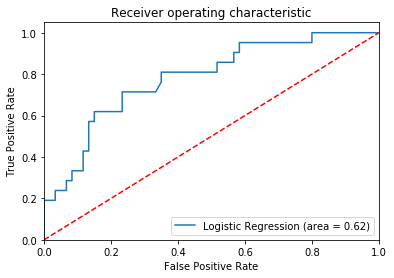

In [316]:
#Generate an ROC visual 
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test.loc[:,rfe.support_]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test.loc[:,rfe.support_])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


### Random Forest

In [317]:
# Instantiate model with 1200 decision trees
rf = RandomForestClassifier(n_estimators = 1200, random_state = 20)
# Train the model on training data
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
            oob_score=False, random_state=20, verbose=0, warm_start=False)

In [318]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))
confusion_matrix3 = confusion_matrix(y_test, predictions)
print(confusion_matrix3)
print(classification_report(y_test, predictions))


Accuracy of random forest classifier on test set: 0.75
[[58  2]
 [18  3]]
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        60
           1       0.60      0.14      0.23        21

   micro avg       0.75      0.75      0.75        81
   macro avg       0.68      0.55      0.54        81
weighted avg       0.72      0.75      0.69        81



In [333]:
rfimportance=pd.DataFrame(rf.feature_importances_.reshape(-1, len(rf.feature_importances_)), columns=X_train.columns)
rfimportance

,commute_time,sit_ratio,sleep_sat,activity,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,back_pain_freq,back_pain_sev
0,0.049737,0.048663,0.061997,0.055074,0.043502,0.044235,0.006593,0.013786,0.015906,0.013605,...,0.000196,0.006375,0.0,0.007123,0.022367,0.01011,0.022482,0.094308,0.016547,0.018248


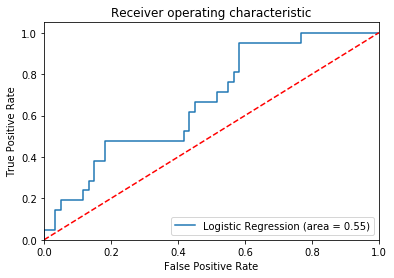

In [321]:
#Generate ROC for Random Forest Classifer
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#Odes not appear to improve upon logistic

In [342]:
#Another way to find feature importance
rfe = RFE(rf)
rfe = rfe.fit(X_m, y.values.ravel())


In [343]:
#using RFE to extract a seperate feature importance table
features=pd.DataFrame([rfe.support_,rfe.ranking_])
features.columns=X_m.columns
features

,commute_time,sit_ratio,sleep_sat,activity,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,back_pain_freq,back_pain_sev
0,True,True,True,True,True,True,False,False,False,False,...,False,False,False,False,True,False,True,True,False,False
1,1,1,1,1,1,1,16,6,3,11,...,23,17,25,14,1,15,1,1,8,4


#### Which features were marked as important for Logistic Regression and Random Forest?

In [345]:
#finding which features where flagged as important in both logistic regression and random forest models
matching=features.iloc[0,:].values.ravel()==(importance.iloc[0,:].values.ravel())

same_feat=pd.DataFrame(matching.reshape(-1, len(matching)), columns=X_train.columns)
same_feat

,commute_time,sit_ratio,sleep_sat,activity,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,back_pain_freq,back_pain_sev
0,True,False,True,False,False,False,True,True,True,False,...,True,False,True,False,True,False,False,False,True,True


##### Important Features:
Age,
Tracker, 
Commute Time,
Sleep Satisfaction,
Commute type,
Country,
Back Pain Frequency and Severity,
Pain location,
Gone to a doctor or had PT,
Gender

### KNN

In [81]:
scores={1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
for n in range(1,13):
    knnmodel=KNeighborsClassifier(n_neighbors=n, )
    knnmodel.fit(X_train,y_train.values.ravel())
    knnpred = knnmodel.predict(X_test)
    scores[n]=knnmodel.score(X_test, y_test)
scores
# N= 4 appears to be the best performing at first glance

{1: 0.6172839506172839,
 2: 0.7283950617283951,
 3: 0.7283950617283951,
 4: 0.7283950617283951,
 5: 0.7037037037037037,
 6: 0.7283950617283951,
 7: 0.7407407407407407,
 8: 0.7407407407407407}

In [347]:
#Train a KNN model with n=4
knnmodel=KNeighborsClassifier(n_neighbors=4)
knnmodel.fit(X_train,y_train.values.ravel())
knnpred = knnmodel.predict(X_test)
print('Accuracy of KNN classifier on test set (w/ n=4): {:.2f}'.format(knnmodel.score(X_test, y_test)))
confusion_matrix4 = confusion_matrix(y_test, knnpred)
print(confusion_matrix4)
print(classification_report(y_test, knnpred))

#similiar results to the RF and LR

Accuracy of KNN classifier on test set (w/ n=4): 0.73
[[58  2]
 [20  1]]
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        60
           1       0.33      0.05      0.08        21

   micro avg       0.73      0.73      0.73        81
   macro avg       0.54      0.51      0.46        81
weighted avg       0.64      0.73      0.64        81



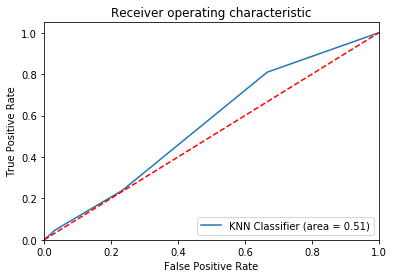

In [348]:
rf_roc_auc = roc_auc_score(y_test, knnpred)
fpr, tpr, thresholds = roc_curve(y_test, knnmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Classifier (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Logistic regression models seemingly outperform RF and KNN. RF and KNN both have a higher proportion of False negatives compared to LR

##### How granular can our classification become?
Attempting to classify more granular states such as "occasional pain" vs "pain most of the time" vs "pain constantly". Previosuly we were classifying "frequent pain" vs "no frequent pain"

In [355]:
#Switch taget variable to the ordinal feature and remove the artificial binary feature
y_f=pd.DataFrame(X["posture"], columns=["posture"])
X_f=X.drop(["posture", "poor_posture"], axis=1)
X_trainf, X_testf, y_trainf, y_testf = ms.train_test_split(X_f, y_f, test_size=0.3, random_state=20)

In [356]:
logreg_f = LogisticRegression(multi_class="multinomial",solver="newton-cg", random_state=20)
rfe_f = RFE(logreg_f)
rfe_f = rfe.fit(X_f, y_f.values.ravel())
importance_f=pd.DataFrame([rfe_f.support_,rfe_f.ranking_])
importance_f.columns=X_f.columns
importance_f

,commute_time,sit_ratio,sleep_sat,activity,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,back_pain_freq,back_pain_sev
0,True,True,True,True,True,True,False,True,False,False,...,False,False,False,False,True,False,True,True,False,False
1,1,1,1,1,1,1,16,1,7,9,...,24,18,25,15,1,14,1,1,10,4


In [358]:
resultred_f=logreg_f.fit(X_trainf.loc[:,rfe_f.support_], y_trainf.values.ravel())
y_pred_f = logreg_f.predict(X_test.loc[:,rfe_f.support_])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_f.score(X_testf.loc[:,rfe_f.support_], y_testf)))
confusion_matrix_f = confusion_matrix(y_testf, y_pred_f)
print(confusion_matrix_f)
print(classification_report(y_testf, y_pred_f))

Accuracy of logistic regression classifier on test set: 0.54
[[ 0  0  1  0  0]
 [ 0  8 11  1  0]
 [ 0 11 27 10  1]
 [ 0  1  1  9  0]
 [ 0  0  0  0  0]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.40      0.40      0.40        20
         3.0       0.68      0.55      0.61        49
         4.0       0.45      0.82      0.58        11
         5.0       0.00      0.00      0.00         0

   micro avg       0.54      0.54      0.54        81
   macro avg       0.31      0.35      0.32        81
weighted avg       0.57      0.54      0.54        81



C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [359]:
# Instantiate model with 1000 decision trees
rf_f = RandomForestClassifier(n_estimators = 1200, random_state = 20)
# Train the model on training data
rf_f.fit(X_trainf, y_trainf.values.ravel())
predictions_f = rf_f.predict(X_testf)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_f.score(X_testf, y_testf)))
confusion_matrixrf_f = confusion_matrix(y_testf, predictions_f)
print(confusion_matrixrf_f)
print(classification_report(y_testf, predictions_f))

Accuracy of random forest classifier on test set: 0.58
[[ 0  1  0  0]
 [ 0  6 14  0]
 [ 0  8 37  4]
 [ 0  1  6  4]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.38      0.30      0.33        20
         3.0       0.65      0.76      0.70        49
         4.0       0.50      0.36      0.42        11

   micro avg       0.58      0.58      0.58        81
   macro avg       0.38      0.35      0.36        81
weighted avg       0.55      0.58      0.56        81



C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As expected, model performance deteriorated while moving to more specific classifications. The random forest regressor performed much worse in perdicting specific posture.

### <a class="anchor" id="pain-severity">Exploring pain severity</a>
Attempting to classify people with and without back pain as we did with poor posture above

In [360]:
y_bpf=pd.DataFrame(X["back_pain_freq"], columns=["back_pain_freq"])
X_bpf=X.drop(["back_pain_freq","pain_freq"], axis=1)
X_trainbpf, X_testbpf, y_trainbpf, y_testbpf = ms.train_test_split(X_bpf, y_bpf, test_size=0.3, random_state=20)

#### Logistic Regression

All Features:
Accuracy of logistic regression classifier on test set: 0.77
[[26 15]
 [ 4 36]]
              precision    recall  f1-score   support

           0       0.87      0.63      0.73        41
           1       0.71      0.90      0.79        40

   micro avg       0.77      0.77      0.77        81
   macro avg       0.79      0.77      0.76        81
weighted avg       0.79      0.77      0.76        81

Reduced Features:
Accuracy of logistic regression classifier on test set: 0.79
[[29 12]
 [ 5 35]]
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        41
           1       0.74      0.88      0.80        40

   micro avg       0.79      0.79      0.79        81
   macro avg       0.80      0.79      0.79        81
weighted avg       0.80      0.79      0.79        81



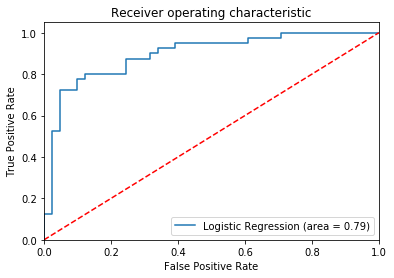

,commute_time,sit_ratio,sleep_sat,activity,posture,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,poor_posture,back_pain_sev
0,False,False,True,False,True,True,False,False,True,False,...,True,False,False,True,False,True,False,False,True,True
1,16,9,1,17,1,1,23,19,1,20,...,1,15,25,1,22,1,7,24,1,1


In [361]:
run_Logistic_Regression(X_bpf,y_bpf,X_trainbpf,y_trainbpf,X_testbpf,y_testbpf)

#### Random Forest

Accuracy of random forest classifier on test set: 0.78
[[29 12]
 [ 6 34]]
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        41
           1       0.74      0.85      0.79        40

   micro avg       0.78      0.78      0.78        81
   macro avg       0.78      0.78      0.78        81
weighted avg       0.78      0.78      0.78        81



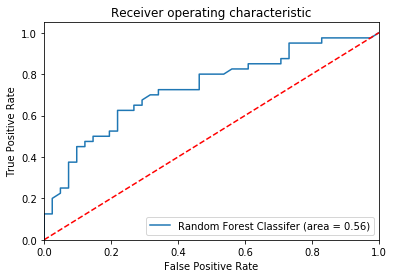

,commute_time,sit_ratio,sleep_sat,activity,posture,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_singapore,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,poor_posture,back_pain_sev
0,0.049737,0.048663,0.061997,0.055074,0.043502,0.044235,0.006593,0.013786,0.015906,0.013605,...,0.000196,0.006375,0.0,0.007123,0.022367,0.01011,0.022482,0.094308,0.016547,0.018248


In [362]:
run_Random_Forest_Classifier(X_trainbpf,y_trainbpf,X_testbpf,y_testbpf)

### <a class="anchor" id="pain-loc">Exploring location of the pain</a>

In [363]:
y_bpl=pd.DataFrame(X[["pain_neck","pain_lower","pain_shoulder"]], columns=["pain_neck","pain_lower","pain_shoulder"])
X_bpl=X.drop(["pain_neck","pain_lower","pain_shoulder"], axis=1)
X_trainbpl, X_testbpl, y_trainbpl, y_testbpl = ms.train_test_split(X_bpl, y_bpl, test_size=0.3, random_state=20)

In [364]:
#Training a RF classifier that will output 3 seperate target predictions for each location (neck, shoulders,etc). 
#Cannot use run_Random_Forest_classifier yet
rf_f = RandomForestClassifier(n_estimators = 1200, random_state = 20)
    # Train the model on training data
rf_f.fit(X_trainbpl, y_trainbpl)
predictions_f = rf_f.predict(X_testbpl)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_f.score(X_testbpl, y_testbpl)))
#confusion_matrixrf_f = confusion_matrix(y_test, predictions_f)
#print(confusion_matrixrf_f)
print(classification_report(y_testbpl, predictions_f))


Accuracy of random forest classifier on test set: 0.31
              precision    recall  f1-score   support

           0       0.50      0.30      0.38        23
           1       0.66      1.00      0.79        52
           2       0.60      0.50      0.55        42

   micro avg       0.62      0.68      0.65       117
   macro avg       0.59      0.60      0.57       117
weighted avg       0.61      0.68      0.62       117
 samples avg       0.63      0.68      0.61       117



C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### <a class="anchor" id="pain-when">Exploring when pain occurs</a>

In [367]:
y_bpw=pd.DataFrame(X[["pain_stand","pain_move","pain_sleep","pain_sed"]], 
                   columns=["pain_stand","pain_move","pain_sleep","pain_sed"])
X_bpw=X.drop(["pain_stand","pain_move","pain_sleep","pain_sed"], axis=1)
X_trainbpw, X_testbpw, y_trainbpw, y_testbpw = ms.train_test_split(X_bpw, y_bpw, test_size=0.3, random_state=20)

In [368]:
#Training a RF classifier that will output 4 seperate target predictions for each time (moving, sleeping,etc). 
#Cannot use run_Random_Forest_classifier yet
rf_f = RandomForestClassifier(n_estimators = 1200, random_state = 20)
    # Train the model on training data
rf_f.fit(X_trainbpw, y_trainbpw)
predictions_w = rf_f.predict(X_testbpw)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_f.score(X_testbpw, y_testbpw)))
#confusion_matrixrf_f = confusion_matrix(y_test, predictions_f)
#print(confusion_matrixrf_f)
print(classification_report(y_testbpw, predictions_w))


Accuracy of random forest classifier on test set: 0.15
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        32
           1       0.53      0.33      0.41        24
           2       0.33      0.05      0.09        19
           3       0.61      0.65      0.63        46

   micro avg       0.54      0.45      0.49       121
   macro avg       0.48      0.38      0.40       121
weighted avg       0.51      0.45      0.46       121
 samples avg       0.37      0.36      0.34       121



C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### <a class="anchor" id="sleep">Predicting Sleeping Habits</a>

##### Sleeping Position

In [369]:
y_s=pd.DataFrame(X[["sleep_pos_On your back","sleep_pos_On your side","sleep_pos_On your stomach"]], 
                   columns=["sleep_pos_On your back","sleep_pos_On your side","sleep_pos_On your stomach"])
X_s=X.drop(["sleep_pos_On your back","sleep_pos_On your side","sleep_pos_On your stomach"], axis=1)
X_trains, X_tests, y_trains, y_tests = ms.train_test_split(X_s, y_s, test_size=0.3, random_state=20)

In [371]:
#Training a RF classifier that will output 3 seperate target predictions for each sleeping position (side, stomach,etc). 
#Cannot use run_Random_Forest_classifier yet
rf_s = RandomForestClassifier(n_estimators = 1200, random_state = 20)
    # Train the model on training data
rf_s.fit(X_trains, y_trains)
predictions_s = rf_s.predict(X_tests)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_s.score(X_tests, y_tests)))
#confusion_matrixrf_f = confusion_matrix(y_test, predictions_f)
#print(confusion_matrixrf_f)
print(classification_report(y_tests, predictions_s))


Accuracy of random forest classifier on test set: 0.60
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.62      0.96      0.75        49
           2       1.00      0.05      0.09        21

   micro avg       0.63      0.60      0.62        81
   macro avg       0.87      0.37      0.34        81
weighted avg       0.77      0.60      0.50        81
 samples avg       0.60      0.60      0.60        81



C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


##### Sleeping Satisifcation
This offers an interesting problem as the response could be considered (and I did consider) ordinal. However, I could not find an existing randomforest implementation that natively handles ordinal outputs. So I ran a regressor and a classifier. The classifer performed better, but all performed worse than the baseline.


In [372]:
y_ss=pd.DataFrame(X["sleep_sat"], columns=["sleep_sat"])
X_ss=X.drop(["sleep_sat"], axis=1)
X_trainss, X_testss, y_trainss, y_testss = ms.train_test_split(X_ss, y_ss, test_size=0.3, random_state=20)

In [264]:
import mord
#attempting to train an ordinal linear regressor to handle the ordinal output of sleep satisfaction
OrR=mord.OrdinalRidge()
OrR.fit(X_trainss,y_trainss)
print('R2 of Oridinal Linear regressor on test set: {:.2f}'.format(OrR.score(X_testss, y_testss)))


R2 of Oridinal Linear regressor on test set: -1.10


In [254]:
#Both regressors and classifiers were tested, but the classification models outperformed each time
rf_ss = RandomForestClassifier(n_estimators = 1200, random_state = 20)
    # Train the model on training data
rf_ss.fit(X_trainss, y_trainss.values.ravel())
predictions_ss = (rf_ss.predict(X_testss))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_ss.score(X_testss, y_testss)))



Accuracy of random forest classifier on test set: 0.40


In [261]:
scores={1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
for n in range(1,13):
    knnmodel=KNeighborsClassifier(n_neighbors=n)
    knnmodel.fit(X_trainss,y_trainss.values.ravel())
    knnpred = knnmodel.predict(X_testss)
    scores[n]=knnmodel.score(X_testss, y_testss)
scores

{1: 0.2716049382716049,
 2: 0.32098765432098764,
 3: 0.4074074074074074,
 4: 0.4074074074074074,
 5: 0.32098765432098764,
 6: 0.345679012345679,
 7: 0.3333333333333333,
 8: 0.3333333333333333,
 9: 0.38271604938271603,
 10: 0.41975308641975306,
 11: 0.43209876543209874,
 12: 0.4074074074074074}

### <a class="anchor" id="activity">Predicitng Activity Level</a>

In [265]:
y_a=pd.DataFrame(X["activity"], 
                   columns=["activity"])
X_a=X.drop(["activity"], axis=1)
X_traina, X_testa, y_traina, y_testa = ms.train_test_split(X_a, y_a, test_size=0.3, random_state=20)

In [275]:
#Multi-target logistic regression for classifying how active a person is
run_Logistic_Regression(X_a,y_a,X_traina, y_traina,X_testa, y_testa, multi_class="multinomial",solver="newton-cg" , extra=False)

All Features:
Accuracy of logistic regression classifier on test set: 0.42
[[ 3  7  3  1  0]
 [ 4 22  8  0  0]
 [ 0 14  7  3  0]
 [ 0  2  4  2  0]
 [ 0  1  0  0  0]]
              precision    recall  f1-score   support

           0       0.43      0.21      0.29        14
           1       0.48      0.65      0.55        34
           2       0.32      0.29      0.30        24
           3       0.33      0.25      0.29         8
           4       0.00      0.00      0.00         1

   micro avg       0.42      0.42      0.42        81
   macro avg       0.31      0.28      0.29        81
weighted avg       0.40      0.42      0.40        81

Reduced Features:
Accuracy of logistic regression classifier on test set: 0.51


C:\Users\John\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,commute_time,sit_ratio,sleep_sat,posture,pain_freq,pain_severe,commute_bike,commute_walk,commute_drive,commute_public,...,country_spain,country_uae,country_usa,tracker_No,"tracker_Own, but do not use",tracker_Yes,age,poor_posture,back_pain_freq,back_pain_sev
0,False,False,True,True,False,True,True,False,True,False,...,False,False,True,True,True,True,False,True,True,True
1,14,2,1,1,4,1,1,5,1,10,...,23,26,1,1,1,1,25,1,1,1


In [266]:
#testing the mord Ordinal regression method again
OrR=mord.OrdinalRidge()
OrR.fit(X_traina,y_traina)
print('R2 of Oridinal Linear regressor on test set: {:.2f}'.format(OrR.score(X_testa, y_testa)))


R2 of Oridinal Linear regressor on test set: -0.83


In [269]:
rf_a = RandomForestClassifier(n_estimators = 1200, random_state = 20)
rf_a.fit(X_traina, y_traina.values.ravel())
predictions_a = (rf_a.predict(X_testa))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf_ss.score(X_testa, y_testa)))


Accuracy of random forest classifier on test set: 0.22


In [271]:
#Knn
scores={1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
for n in range(1,13):
    knnmodel=KNeighborsClassifier(n_neighbors=n)
    knnmodel.fit(X_traina,y_traina.values.ravel())
    knnpred = knnmodel.predict(X_testa)
    scores[n]=knnmodel.score(X_testa, y_testa)
scores[2]

0.41975308641975306